# Homework 1: Finding Similar Items - Textually Similar Documents

This notebook implements a pipeline to find **textually similar documents**

---

## Overview

Given a corpus of documents, the goal is to efficiently detect pairs with high textual overlap without all-pairs comparison (O(N²)).  
We apply three main techniques:

1. **Shingling** – Convert each document into a set of hashed *k-shingles* (substrings of length *k*) to capture content structure.  
2. **MinHashing** – Generate compact signatures that approximate Jaccard similarity between documents.  
3. **Locality-Sensitive Hashing (LSH)** – Use banding and hashing to quickly identify candidate pairs likely to be similar.

---

## Components

- `Shingling`: builds k-shingles and hashes them.  
- `CompareSets`: computes Jaccard similarity.  
- `MinHashing`: creates signature vectors of fixed length.  
- `CompareSignatures`: estimates similarity between signatures.  
- `LSH`: efficiently finds candidate document pairs above a threshold *t*.

---

## Dataset & Experiment

We test the pipeline on a small corpus of 8 documents selected from the **"20 Newsgroups"** dataset.

The *ratio* for this selection is to test the algorithm's performance on documents with varying levels of expected similarity. The documents are drawn from three distinct groups:
* `comp.sys.ibm.pc.hardware`
* `comp.sys.mac.hardware`
* `rec.sport.baseball`

This mix is designed to find pairs that are highly dissimilar (e.g., 'hardware' vs 'baseball') and moderately similar (e.g., 'pc' vs 'mac'). As observed in the results, the pipeline correctly identifies the two documents from `rec.sport.baseball` as the most similar pair , validating its effectiveness.  

---

## 0) Setup and Load Documents

We load a small corpus of documents and set the key parameters:
- `k` for shingling,
- `MINHASH_SIGNATURE_SIZE` for signature length,
- similarity threshold `s` used to classify document pairs as similar.

In [146]:
import os
import glob
import re
import time
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Custom modules
from src import Shingling
from src import CompareSets
from src import MinHashing
from src import CompareSignatures
from src import LSH

DATA_DIR = 'data/'

# The 'k' in k-shingles
SHINGLE_LENGTH = 5

# The number of hash functions for MinHashing (signature length 'n')
# More hashes = better accuracy, but slower.
MINHASH_SIGNATURE_SIZE = 100

# The Jaccard similarity threshold 's'
SIMILARITY_THRESHOLD = 0.2

doc_files = sorted(glob.glob(os.path.join(DATA_DIR, '*.txt')))
num_docs = len(doc_files)

docs = []
doc_names = []
for doc_path in doc_files:
    doc_names.append(os.path.basename(doc_path))
    try:
        with open(doc_path, 'r', encoding='utf-8') as f:
            docs.append(f.read())
    except Exception as e:
        print(f"Could not read {doc_path}: {e}")

print(f"\nSuccessfully loaded {len(docs)} documents.")

def clean_text(text: str) -> str:
    """A simple text cleaner."""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove all punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Compact all whitespace into a single space
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()


Successfully loaded 8 documents.


## 1) Shingling

We convert each document into a set of **hashed k-shingles**.  
This preserves local ordering and is robust to small edits.  
Output: one integer set per document (`doc_shingle_sets`).

In [147]:
print(f"\n--- Shingling (k={SHINGLE_LENGTH}) ---")
start_time = time.time()

shingler = Shingling.Shingling(k=SHINGLE_LENGTH)

# This list will hold the set of hashed shingles for each document
doc_shingle_sets = []

for i in range(num_docs):
    doc_content = docs[i]
    
    cleaned_doc = clean_text(doc_content)
    hashed_shingles_list = shingler.get_hashed_shingles(cleaned_doc)
    shingles_set = set(hashed_shingles_list)
    
    doc_shingle_sets.append(shingles_set)
    print(f"  '{doc_names[i]}' -> {len(shingles_set)} unique shingles.")

print(f"\nShingling all documents took {time.time() - start_time:.4f} seconds.")


--- Shingling (k=5) ---
  '100521.txt' -> 1927 unique shingles.
  '102612.txt' -> 1253 unique shingles.
  '50433.txt' -> 440 unique shingles.
  '50444.txt' -> 299 unique shingles.
  '51676.txt' -> 459 unique shingles.
  '58835.txt' -> 784 unique shingles.
  '58915.txt' -> 1690 unique shingles.
  '58917.txt' -> 715 unique shingles.

Shingling all documents took 0.0052 seconds.


## 2) Exact Jaccard Similarity

We compute the **true Jaccard similarity** for every document pair from their shingle sets.  
Pairs with similarity ≥ `s` are recorded as ground-truth similar pairs (`ground_truth_similar_pairs`).  
We also visualize the full pairwise similarity matrix and the Top-K pairs.

In [148]:
print(f"\n--- Jaccard Similarity (Threshold s={SIMILARITY_THRESHOLD}) ---")
start_time = time.time()

ground_truth_similar_pairs = []

_ = CompareSets.CompareSets.calculate_jaccard

for i in range(num_docs):
    for j in range(i + 1, num_docs):
        set1 = doc_shingle_sets[i]
        set2 = doc_shingle_sets[j]
        
        j_sim = CompareSets.CompareSets.calculate_jaccard(set1, set2)
        
        # If similarity is above our threshold, record it
        if j_sim >= SIMILARITY_THRESHOLD:
            pair = tuple(sorted((doc_names[i], doc_names[j])))
            ground_truth_similar_pairs.append((pair, j_sim))
            print(f"  {pair} | Jaccard = {j_sim:.4f}")

print(f"\nFound {len(ground_truth_similar_pairs)} true similar pairs.")
print(f"Comparison took {time.time() - start_time:.4f} seconds.")


--- Jaccard Similarity (Threshold s=0.2) ---
  ('100521.txt', '102612.txt') | Jaccard = 0.6502
  ('58915.txt', '58917.txt') | Jaccard = 0.2116

Found 2 true similar pairs.
Comparison took 0.0032 seconds.


### 2b) Visualization of Jaccard Similarities

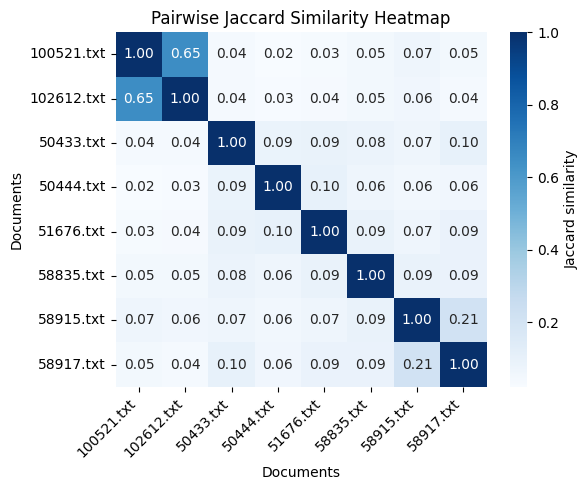

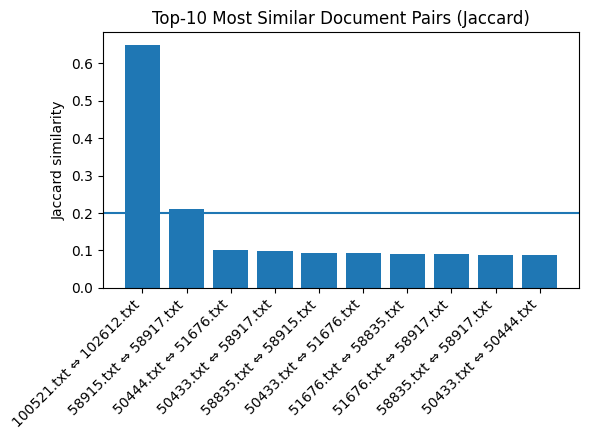

In [149]:
# Build full similarity matrix (including diagonal)
sim_matrix = np.zeros((num_docs, num_docs), dtype=float)
df_sim = pd.DataFrame(sim_matrix, index=doc_names, columns=doc_names)

for i in range(num_docs):
    for j in range(num_docs):
        if i == j:
            sim_matrix[i, j] = 1.0
        elif j > i:
            sim_ij = CompareSets.CompareSets.calculate_jaccard(doc_shingle_sets[i], doc_shingle_sets[j])
            sim_matrix[i, j] = sim_ij
            sim_matrix[j, i] = sim_ij

# 1) Heatmap of pairwise Jaccard similarities

plt.figure(figsize=(max(6, 0.6 * num_docs), max(5, 0.6 * num_docs)))
sns.heatmap(df_sim, annot=True, fmt=".2f", cmap="Blues", cbar_kws={'label': 'Jaccard similarity'})
plt.title("Pairwise Jaccard Similarity Heatmap")
plt.xlabel("Documents")
plt.ylabel("Documents")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 2) Bar chart of Top-K most similar pairs (excluding diagonal)
K = min(10, (num_docs * (num_docs - 1)) // 2)

pairs = []
for i in range(num_docs):
    for j in range(i + 1, num_docs):
        pairs.append(((doc_names[i], doc_names[j]), sim_matrix[i, j]))

# Sort by similarity descending
pairs_sorted = sorted(pairs, key=lambda x: x[1], reverse=True)
top_pairs = pairs_sorted[:K]

# Prepare data for plotting
labels = [f"{a} ⇔ {b}" for (a, b), _ in top_pairs]
values = [v for _, v in top_pairs]

plt.figure(figsize=(max(6, 0.35 * len(top_pairs) + 2), 4.5))
plt.bar(range(len(top_pairs)), values)
plt.title(f"Top-{K} Most Similar Document Pairs (Jaccard)")
plt.ylabel("Jaccard similarity")
plt.xticks(ticks=range(len(top_pairs)), labels=labels, rotation=45, ha='right')
# Draw threshold
try:
    _ = SIMILARITY_THRESHOLD
    plt.axhline(SIMILARITY_THRESHOLD)
except NameError:
    pass
plt.tight_layout()
plt.show()

## 3) MinHashing

We compress large shingle sets into fixed-length **MinHash signatures** of size `n`.  
The fraction of matching components between two signatures estimates their Jaccard similarity.

In [150]:
print(f"\n--- Minhashing (Signature Size n={MINHASH_SIGNATURE_SIZE}) ---")
start_time = time.time()

# This list will hold the MinHash signatures (vectors) for each document
doc_signatures = []

minhasher = MinHashing.MinHashing(num_hashes=MINHASH_SIGNATURE_SIZE)

for i in range(num_docs):
    shingle_set = doc_shingle_sets[i]
    
    signature = minhasher.get_signature(shingle_set)
    doc_signatures.append(signature)

print(f"\nMinhashing all documents took {time.time() - start_time:.4f} seconds.")

print(f"\n--- Signature Comparison (Threshold s={SIMILARITY_THRESHOLD}) ---")
start_time = time.time()

minhash_similar_pairs = []

_ = CompareSignatures.CompareSignatures.calculate_similarity

for i in range(num_docs):
    for j in range(i + 1, num_docs):
        sig1 = doc_signatures[i]
        sig2 = doc_signatures[j]
        
        est_sim = CompareSignatures.CompareSignatures.calculate_similarity(sig1, sig2)
        
        # If estimated similarity is above our threshold, record it
        if est_sim >= SIMILARITY_THRESHOLD:
            pair = tuple(sorted((doc_names[i], doc_names[j])))
            minhash_similar_pairs.append((pair, est_sim))
            print(f" {pair} | Est. Sim = {est_sim:.4f}")

print(f"\nFound {len(minhash_similar_pairs)} estimated similar pairs.")
print(f"Signature comparison took {time.time() - start_time:.4f} seconds.")


--- Minhashing (Signature Size n=100) ---

Minhashing all documents took 0.1517 seconds.

--- Signature Comparison (Threshold s=0.2) ---
 ('100521.txt', '102612.txt') | Est. Sim = 0.6900

Found 1 estimated similar pairs.
Signature comparison took 0.0003 seconds.


### 3b) MinHash vs Jaccard Evaluation
We compare the estimated pairs to the ground truth:
- **Precision**: of the pairs we predicted, how many were truly similar?
- **Recall**: of the truly similar pairs, how many did we recover?
We also report F1 (when applicable).

In [151]:
true_pairs_set = set([pair[0] for pair in ground_truth_similar_pairs])
est_pairs_set = set([pair[0] for pair in minhash_similar_pairs])

if not true_pairs_set and not est_pairs_set:
    print("No similar pairs found by either method.")
else:
    true_positives = len(true_pairs_set.intersection(est_pairs_set))
    false_positives = len(est_pairs_set.difference(true_pairs_set))
    false_negatives = len(true_pairs_set.difference(est_pairs_set))

    print(f"True Positives:  {true_positives}")
    print(f"False Positives: {false_positives}")
    print(f"False Negatives: {false_negatives}")

    # Precision and Recall
    if (true_positives + false_positives) > 0:
        precision = true_positives / (true_positives + false_positives)
        print(f"Precision: {precision:.4f}")
    else:
        print("Precision: N/A (no positive estimations)")
        
    if (true_positives + false_negatives) > 0:
        recall = true_positives / (true_positives + false_negatives)
        print(f"Recall:    {recall:.4f}")
    else:
        print("Recall:    N/A (no true pairs to find)")

print("\n--- Summary ---")
print(f"Jaccard Similarity:     {len(true_pairs_set)} pairs")
print(f"MinHash Estimate:       {len(est_pairs_set)} pairs")

True Positives:  1
False Positives: 0
False Negatives: 1
Precision: 1.0000
Recall:    0.5000

--- Summary ---
Jaccard Similarity:     2 pairs
MinHash Estimate:       1 pairs


### 3c) MinHash vs Jaccard Visualization
We visualize how MinHash estimates track true Jaccard:
- **Scatter plot** of estimated vs true similarities,
- **Grouped bars** per pair to compare values,
- Threshold line at `s` for clarity.

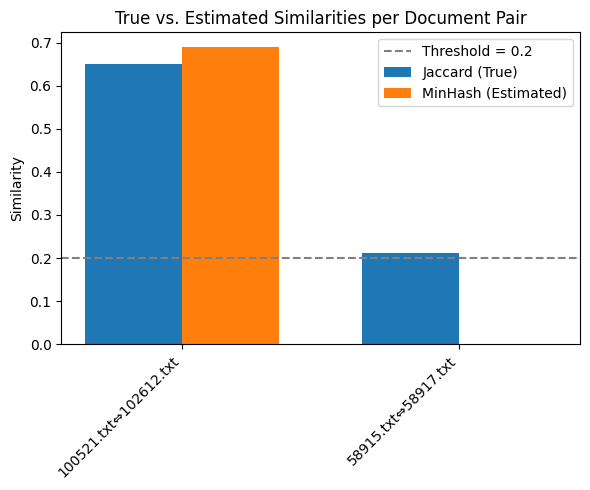

In [152]:
# If either list is empty, skip visualization
if not ground_truth_similar_pairs and not minhash_similar_pairs:
    print("No similar pairs to visualize.")
else:
    # Prepare data
    gt_pairs = {pair: sim for pair, sim in ground_truth_similar_pairs}
    mh_pairs = {pair: sim for pair, sim in minhash_similar_pairs}

    # Collect all unique pairs that appear in either set
    all_pairs = sorted(set(gt_pairs.keys()) | set(mh_pairs.keys()))
    jaccard_vals = [gt_pairs.get(p, 0) for p in all_pairs]
    minhash_vals = [mh_pairs.get(p, 0) for p in all_pairs]

    # --- Bar chart: Compare similarities for each pair ---
    x = np.arange(len(all_pairs))
    width = 0.35
    plt.figure(figsize=(max(6, 0.4 * len(all_pairs) + 2), 5))
    plt.bar(x - width/2, jaccard_vals, width, label="Jaccard (True)")
    plt.bar(x + width/2, minhash_vals, width, label="MinHash (Estimated)")
    plt.xticks(x, [f"{a}⇔{b}" for (a,b) in all_pairs], rotation=45, ha='right')
    plt.ylabel("Similarity")
    plt.title("True vs. Estimated Similarities per Document Pair")
    plt.axhline(SIMILARITY_THRESHOLD, color='gray', linestyle='--', label=f"Threshold = {SIMILARITY_THRESHOLD}")
    plt.legend()
    plt.tight_layout()
    plt.show()

## 4) Locality Sensitive Hashing
We apply **Locality-Sensitive Hashing (LSH)** on signatures:
- Split signatures into `b` bands of `r` rows (`b*r = n`),
- Hash each band to buckets to generate **candidate pairs**,
- Finally, re-check candidates with signature similarity ≥ `s`.
This reduces pair comparisons drastically while retaining most true matches.

In [153]:
print(f"\n--- LSH Candidate Finding & Final Comparison ---")
start_lsh_time = time.time()

# We must choose 'b' (bands) and 'r' (rows) so that b * r = n (signature size)
# The "sweet spot" threshold 's' is approximately (1/b)^(1/r)
NUM_BANDS = 20

# Check if our signature size is divisible by the number of bands
if MINHASH_SIGNATURE_SIZE % NUM_BANDS != 0:
    print(f"ERROR: MINHASH_SIGNATURE_SIZE ({MINHASH_SIGNATURE_SIZE})")
    print(f"is not divisible by NUM_BANDS ({NUM_BANDS}).")
    raise ValueError("LSH band configuration error")
else:
    rows_per_band = MINHASH_SIGNATURE_SIZE // NUM_BANDS

lsh = LSH.LSH(num_bands=NUM_BANDS, num_hashes=MINHASH_SIGNATURE_SIZE)

for i, signature in enumerate(doc_signatures):
    doc_id = doc_names[i]
    lsh.add_signature(doc_id, signature)

# Get candidate pairs
candidate_pairs = lsh.get_candidate_pairs()
lsh_indexing_time = time.time() - start_lsh_time

total_possible_pairs = num_docs * (num_docs - 1) // 2
print(f"\nLSH indexing took {lsh_indexing_time:.4f} seconds.")
print(f"Reduced {total_possible_pairs} total pairs to {len(candidate_pairs)} candidate pairs.")

# Final check on candidate pairs
start_check_time = time.time()

lsh_similar_pairs = []

signature_map = {doc_names[i]: doc_signatures[i] for i in range(num_docs)}

for pair in candidate_pairs:
    doc_a_name, doc_b_name = pair
    sig1 = signature_map[doc_a_name]
    sig2 = signature_map[doc_b_name]
    
    est_sim = CompareSignatures.CompareSignatures.calculate_similarity(sig1, sig2)
    
    if est_sim >= SIMILARITY_THRESHOLD:
        sorted_pair = tuple(sorted(pair))
        lsh_similar_pairs.append((sorted_pair, est_sim))
        print(f" {sorted_pair} | Est. Sim = {est_sim:.4f}")

check_time = time.time() - start_check_time
total_time = time.time() - start_lsh_time

print(f"\nFinal check took {check_time:.4f} seconds.")
print(f"Total LSH process took {total_time:.4f} seconds.")
print(f"\nFound {len(lsh_similar_pairs)} estimated similar pairs.")


--- LSH Candidate Finding & Final Comparison ---
  Total Hashes (n): 100
  Bands (b): 20
  Rows per Band (r): 5

LSH indexing took 0.0004 seconds.
Reduced 28 total pairs to 1 candidate pairs.
 ('100521.txt', '102612.txt') | Est. Sim = 0.6900

Final check took 0.0001 seconds.
Total LSH process took 0.0006 seconds.

Found 1 estimated similar pairs.


## 4b) LSH Evaluation and Visualization
We show:
- **True vs Estimated** similarities for LSH pairs (scatter),
- **Per-pair bars** comparing Jaccard vs LSH estimates,
- **Reduction chart**: total pairs → LSH candidates → true pairs → LSH-found pairs.

True Positives (found by LSH, is true):   1
False Positives (found by LSH, not true): 0
False Negatives (MISSED by LSH, is true): 1
Precision: 1.0000 (Of the pairs LSH *found*, % were correct)
Recall:    0.5000 (of the pairs that exist, % LSH found)

--- Summary (LSH) ---
Jaccard Similarity: 2 pairs
LSH Estimate:       1 pairs


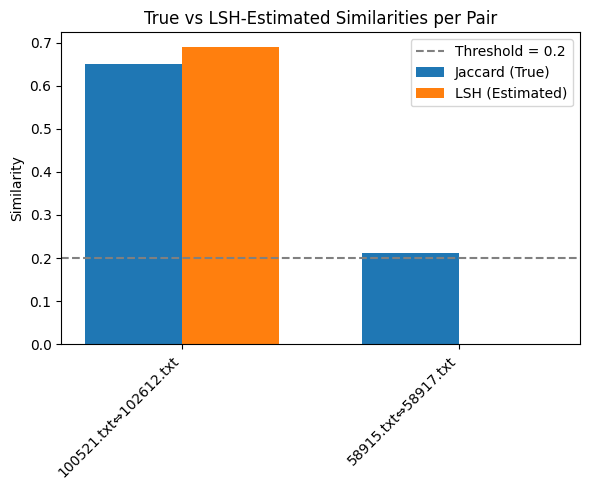

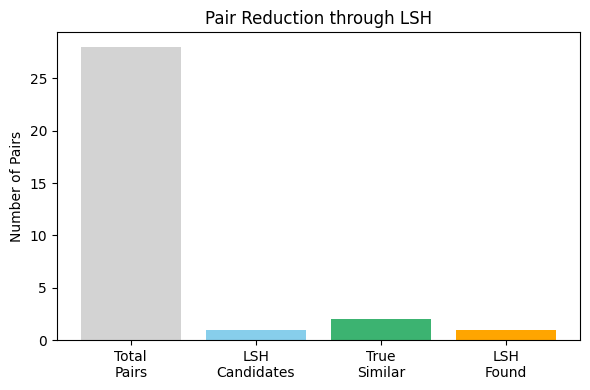

In [154]:
true_pairs_set = set([pair[0] for pair in ground_truth_similar_pairs])

lsh_pairs_set = set([pair[0] for pair in lsh_similar_pairs])

if not true_pairs_set and not lsh_pairs_set:
    print("No similar pairs found by either method.")
else:    
    # True Positives: LSH found it, and it was a real match
    true_positives = len(true_pairs_set.intersection(lsh_pairs_set))

    # False Positives: LSH found it, but it was not a real match.
    # This happens if LSH (b, r) params are too loose OR MinHash was wrong.
    false_positives = len(lsh_pairs_set.difference(true_pairs_set))

    # False Negatives: LSH missed it, but it was a real match.
    # This is the "cost" of LSH. We trade 100% recall for speed.
    false_negatives = len(true_pairs_set.difference(lsh_pairs_set))

    print(f"True Positives (found by LSH, is true):   {true_positives}")
    print(f"False Positives (found by LSH, not true): {false_positives}")
    print(f"False Negatives (MISSED by LSH, is true): {false_negatives}")

    # Precision and Recall
    if (true_positives + false_positives) > 0:
        precision = true_positives / (true_positives + false_positives)
        print(f"Precision: {precision:.4f} (Of the pairs LSH *found*, % were correct)")
    else:
        print("Precision: N/A (LSH found no pairs)")
        
    if (true_positives + false_negatives) > 0:
        recall = true_positives / (true_positives + false_negatives)
        print(f"Recall:    {recall:.4f} (of the pairs that exist, % LSH found)")
    else:
        print("Recall:    N/A (no true pairs to find)")

print("\n--- Summary (LSH) ---")
print(f"Jaccard Similarity: {len(true_pairs_set)} pairs")
print(f"LSH Estimate:       {len(lsh_pairs_set)} pairs")

# Skip visualization if no results
if not lsh_similar_pairs and not ground_truth_similar_pairs:
    print("No LSH or Jaccard pairs to visualize.")
else:
    # Convert pairs to dictionaries for quick lookup
    gt_pairs = {pair: sim for pair, sim in ground_truth_similar_pairs}
    lsh_pairs = {pair: sim for pair, sim in lsh_similar_pairs}

    # Combine all unique pairs seen
    all_pairs = sorted(set(gt_pairs.keys()) | set(lsh_pairs.keys()))
    jaccard_vals = [gt_pairs.get(p, 0) for p in all_pairs]
    lsh_vals = [lsh_pairs.get(p, 0) for p in all_pairs]

    # --- Bar Chart: LSH vs True Similarities ---
    x = np.arange(len(all_pairs))
    width = 0.35
    plt.figure(figsize=(max(6, 0.4 * len(all_pairs) + 2), 5))
    plt.bar(x - width/2, jaccard_vals, width, label="Jaccard (True)")
    plt.bar(x + width/2, lsh_vals, width, label="LSH (Estimated)")
    plt.xticks(x, [f"{a}⇔{b}" for (a,b) in all_pairs], rotation=45, ha='right')
    plt.ylabel("Similarity")
    plt.title("True vs LSH-Estimated Similarities per Pair")
    plt.axhline(SIMILARITY_THRESHOLD, color='gray', linestyle='--', label=f"Threshold = {SIMILARITY_THRESHOLD}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Reduction Chart: Total vs Candidate vs True Pairs ---
    total_possible = num_docs * (num_docs - 1) // 2
    candidate_count = len(candidate_pairs)
    true_count = len([p for p, _ in ground_truth_similar_pairs])
    lsh_count = len([p for p, _ in lsh_similar_pairs])

    plt.figure(figsize=(6, 4))
    plt.bar(["Total\nPairs", "LSH\nCandidates", "True\nSimilar", "LSH\nFound"],
            [total_possible, candidate_count, true_count, lsh_count],
            color=["lightgray", "skyblue", "mediumseagreen", "orange"])
    plt.title("Pair Reduction through LSH")
    plt.ylabel("Number of Pairs")
    plt.tight_layout()
    plt.show()